<a href="https://colab.research.google.com/github/DaniilDChernov/MSU_AI_tasks/blob/main/Chernov_EX03_Classic_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задание 1. Bootstrap

В этом задании используйте датасет breast_cancer — классический датасет для задачи бинарной классификации. Обучите модели:

 - `DecisionTreeClassifier`
 - `RandomForestClassifier`
 - `LigthGBMClassifier`
 - `SVC`
 - `BaggingClassifier` с базовым класификатором `SVC`.

Параметры моделей можете оставить по умолчанию или задать сами.

Для каждой модели посчитайте [корреляцию Мэтьюса](https://en.wikipedia.org/wiki/Phi_coefficient) — метрику для оценки качества бинарной классификации, в частности, устойчивую к дисбалансу классов, ([`sklearn.metrics.matthews_corrcoef`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html), подробнее почитать про его пользу можно [здесь](https://bmcgenomics.biomedcentral.com/articles/10.1186/s12864-019-6413-7)) — для предсказанного ею класса и реального.

С помощью bootstrap-подхода постройте 90% доверительные интервалы для качества полученных моделей. Используйте функцию `bootstrap_metric()` из лекции.

Постройте [боксплоты](https://seaborn.pydata.org/generated/seaborn.boxplot.html) для качества полученных моделей.

Импорт необходимых библиотек:

In [ ]:
import lightgbm
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.datasets
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.metrics import matthews_corrcoef
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier

Загрузка датасета:

In [ ]:
breast_cancer = sklearn.datasets.load_breast_cancer()
print(breast_cancer.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

In [ ]:
x = breast_cancer.data
y = breast_cancer.target
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

In [ ]:
def bootstrap_metric(x, y, metric_fn, samples_cnt=1000, random_state=42):
    np.random.seed(random_state)
    b_metric = np.zeros(samples_cnt)
    for it in range(samples_cnt):
        poses = np.random.choice(x.shape[0], size=x.shape[0], replace=True)

        x_boot = x[poses]
        y_boot = y[poses]
        m_val = metric_fn(x_boot, y_boot)
        b_metric[it] = m_val

    return b_metric

In [ ]:
# Your code here
clf = dict()

names_of_clf = ['DecisionTreeClassifier',
                'RandomForestClassifier',
                'LigthGBMClassifier',
                'SVC',
                'BaggingClassifier']

clf['DecisionTreeClassifier'] = DecisionTreeClassifier()
clf['RandomForestClassifier'] = RandomForestClassifier()
clf['LigthGBMClassifier'] = lightgbm.LGBMClassifier(
    n_estimators=2000,  # can use more estimators due to SPEEEEEED
    learning_rate=0.1,
    max_depth=-1,
    num_leaves=2**5,
    random_state=42,
    min_child_weight=9,
    n_jobs=-1,
    force_col_wise=True,
    verbose=-1,
)
clf['SVC'] =  SVC()
clf['BaggingClassifier'] =  BaggingClassifier()

for name in names_of_clf:
    clf[name].fit(x_train, y_train)

In [ ]:
boot_cor = dict()

for name in names_of_clf:
    print(name)
    boot_cor[name] = bootstrap_metric(
        x= clf[name].predict(x_test).round(),
        y= y_test,
        metric_fn=lambda x, y: matthews_corrcoef(x, y),
)

DecisionTreeClassifier
RandomForestClassifier
LigthGBMClassifier
SVC
BaggingClassifier


In [ ]:
alpha = 0.05
for name in names_of_clf:
    lo, hi = np.quantile(boot_cor[name], q=[alpha / 2, 1 - alpha / 2])
    print(f"{name} confidence interval (bootstap): [{lo:.3f}, {hi:.3f}]")

DecisionTreeClassifier confidence interval (bootstap): [0.797, 0.955]
RandomForestClassifier confidence interval (bootstap): [0.881, 0.986]
LigthGBMClassifier confidence interval (bootstap): [0.856, 0.985]
SVC confidence interval (bootstap): [0.817, 0.969]
BaggingClassifier confidence interval (bootstap): [0.771, 0.940]


In [ ]:
#print(["Log-reg"] * 1000 + ["SVC"] * 1000 + ["DT"] * 1000 + ["DT1"] * 1000 + ["DT2"] * 1000)
#print(np.sum([[name] * 1000 for name in names_of_clf ]))
np.concatenate([[name] * 1000  for name in names_of_clf])

array(['DecisionTreeClassifier', 'DecisionTreeClassifier',
       'DecisionTreeClassifier', ..., 'BaggingClassifier',
       'BaggingClassifier', 'BaggingClassifier'], dtype='<U22')

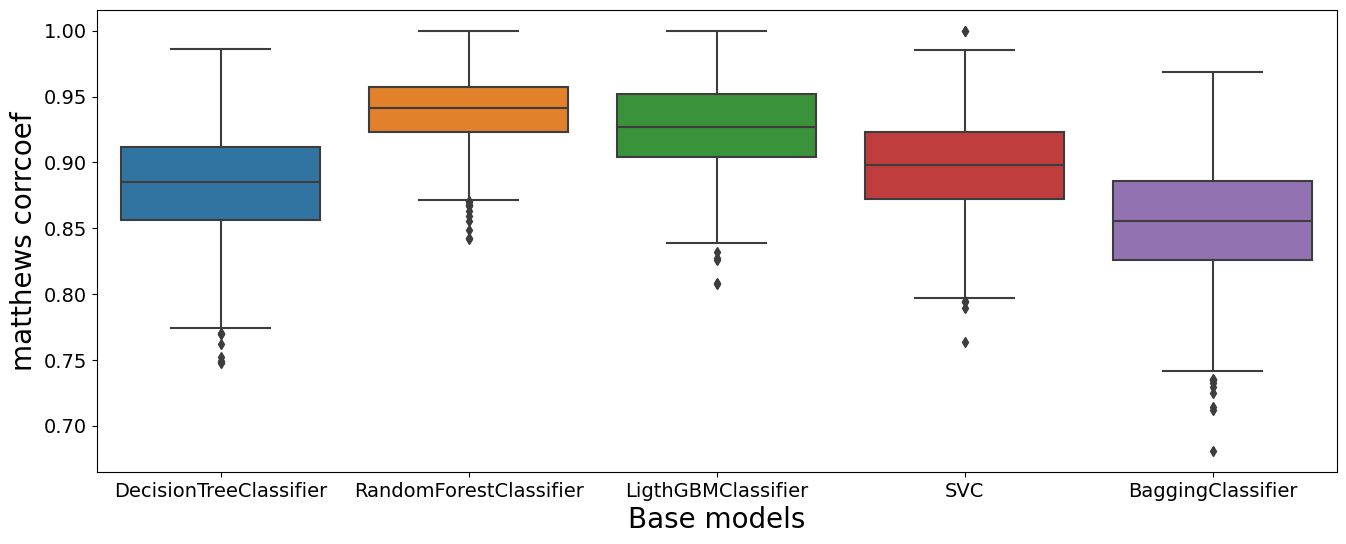

In [ ]:
plt.figure(figsize=(16, 6))
sns.boxplot(
    y = np.concatenate([boot_cor[name] for name in names_of_clf ]),
    x = np.concatenate([[name] * 1000  for name in names_of_clf])
)
plt.ylabel("matthews corrcoef", size=20)
plt.xlabel("Base models", size=20)
plt.tick_params(axis="both", which="major", labelsize=14)
plt.show()

Сделайте вывод о том, какие модели работают лучше.

**Напишите вывод**

## Формат результата

График с демонстрацией корреляции Мэтьюса для следующих моделей:

 - `DecisionTreeClassifier`
 - `RandomForestClassifier`
 - `LigthGBMClassifier`
 - `SVC`
 - `BaggingClassifier` с базовым класификатором `SVC`

Пример графика:

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/Exercises/EX03/result_1_task_ex03.png" width="600">

# Задание 2. Дисбаланс классов

Установка и импорт необходимых библиотек:

In [ ]:
!pip install -qU imbalanced-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 4.5 MB/s eta 0:00:00


In [ ]:
import imblearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import (
    train_test_split,
    KFold,
    StratifiedKFold,
    cross_validate,
)

Важно обращать внимание на сбалансированность классов в наборе.
Предположим, у нас есть некоторый набор данных со следующими метками классов:

In [ ]:
real_labels = [1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]

В наборе 16 объектов относятся к классу 0, а 5 — к классу 1.

Мы обучили две модели. Первая всегда выдает 0:

In [ ]:
model1_res = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Вторая сумела обнаружить некоторую закономерность в признаках:

In [ ]:
model2_res = [1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1]

Рассчитаем точность Accuracy (см. лекцию 1) для этих моделей:

In [ ]:
print("Accuracy for model1: ", accuracy_score(real_labels, model1_res))
print("Accuracy for model2: ", accuracy_score(real_labels, model2_res))

Accuracy for model1:  0.7619047619047619
Accuracy for model2:  0.7619047619047619


Accuracy нельзя использовать, если данные не сбалансированы. Для несбалансированных данных необходимо использовать свои метрики и модели. Одной из таких метрик является balanced accuracy. При вычислении данной метрики считается полнота (recall) отдельно для каждого класса и вычисляется среднее значение:

In [ ]:
# Balanced accuracy for model1 = (16/16+0/5)/2 = 0.5
print(
    "Balanced accuracy for model1: ", balanced_accuracy_score(real_labels, model1_res)
)
# Balanced accuracy for model2 = (12/16+4/5)/2 = 0.775
print(
    "Balanced accuracy for model2: ", balanced_accuracy_score(real_labels, model2_res)
)

Balanced accuracy for model1:  0.5
Balanced accuracy for model2:  0.775


**Всегда проверяйте**, являются ли ваши данные сбалансированными и могут ли выбранные для оценки модели метрики работать с несбалансированными классами.

Загрузим датасет с различными биомаркерами пациентов с меланомой (обезличенный, информации о пациентах нет) и переменной, содержащей 1, если пациент ответил на иммунотерапию (терапия помогла пациенту и произошло уменьшение размеров опухоли), и 0, если не ответил. Количество пациентов, отвечающих на терапию, сильно меньше пациентов, которым терапия не помогает, поэтому предсказание ответа пациента на терапию на основании биомаркеров — актуальная задача в онкологии. В данном задании вам предстоит попробовать её решить.

In [ ]:
cancer = pd.read_table(
    "https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/Cancer_dataset_2.tsv",
    index_col="sample_id",
)
display(cancer.head())

# split the data on features (x) and dependant variable (y)
y = cancer["Response"]
x = cancer.drop("Response", axis=1)
print("\nNumber of patients responded to immunotherapy:")
display(y.value_counts())

,IgG1/IgA,IL21,CXCL9,CXCL10,CD8A,GZMB,KLRC2,KLRC3,KLRC4,GNLY,TGFB1,Response
sample_id,,,,,,,,,,,,
SAM4b0175e8db6e,3.242746,0.001280,-0.002986,-0.036366,0.096658,0.063467,0.502058,-0.083862,0.053659,0.091930,61.934119,0
SAMd215b503f99a,2.139016,-0.000089,0.030495,0.243958,0.161128,0.565798,-0.203495,-0.026902,-0.035405,0.030125,103.265837,0
SAM7fb6987514a4,12.614972,0.008103,0.502043,0.530783,0.388455,0.528142,-0.156209,0.001147,-0.028690,0.260703,53.552817,0
SAMd636e3461955,6.365973,-0.000139,0.024035,0.115127,0.084455,0.200038,-0.387373,-0.057837,0.045938,0.073192,80.837318,0
SAMc0da5d48686d,2.764089,0.006107,0.015533,0.135470,0.067686,0.053499,-0.116040,0.063714,0.088201,0.082940,114.422926,0



Number of patients responded to immunotherapy:


0    228
1     37
Name: Response, dtype: int64

В данном случае имеет место несбалансированность классов в наборе данных: пациентов, ответивших на терапию, гораздо меньше.

Есть два способа работы с несбалансированными по классам данными. Первый способ &mdash; это получение стратифицированных выборок. Необходимо иметь одинаковую долю образцов каждого класса в тренировочной и тестовой выборках, иначе возникает риск получения смещённых выборок, что приводит к некорректной оценке качества модели. Второй способ &mdash; это использование специальных алгоритмов, учитывающих несбалансированность классов.


В данном задании вам нужно продемонстрировать эффективность различных подходов  работы с несбалансированными выборками. Для этого вы будете использовать три модели, представленные ниже:

1. [`RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), библиотека sklearn
2. [`RandomForestClassifier` с балансировкой классов](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), библиотека sklearn — меняет стандартный вес каждого класса, равный 1, на долю класса во входных данных (см. `class_weight`).
3. [`BalancedRandomForestClassifier`](https://imbalanced-learn.org/stable/references/generated/imblearn.ensemble.BalancedRandomForestClassifier.html), библиотека imblearn — сэмплирует псевдовыборки таким образом, что в каждой псевдовыборке, которая подается на вход модели, баланс классов оказывается "выправлен".

Оцените эффективность подходов с помощью кросс-валидации, производя разбиение с учетом репрезентации классов и без него. В качестве метрики, отображающей эффективность модели, используйте значения `accuracy` и `balanced_accuracy`. Проинтерпретируйте результаты.

In [ ]:
?imblearn.ensemble.BalancedRandomForestClassifier

In [ ]:
?cross_validate

Объекты, принадлежащие разным классам, распределены неравномерно. Для адекватной работы cross_validate нужно перемешать данные. Для этого используйте флаг `shuffle=True`, применяя `KFold` и `StratifiedKFold` (см. параметр `cv` в функции cross_validate).

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

print('clf = RandomForestClassifier\n')

np.random.seed(42)

x_train, x_test, y_train, y_test = train_test_split(
    x, y, train_size=0.8, random_state=42, shuffle=True
)

cv = StratifiedKFold(n_splits=4)
rfc = RandomForestClassifier()
balanced_accuracy = cross_val_score(rfc, x_train, y_train, cv=cv, scoring = 'balanced_accuracy')
accuracy = cross_val_score(rfc, x_train, y_train, cv=cv, scoring = 'accuracy')

print('Split with stratify = False')
print(f'accuracy = {accuracy.round(2)}')
print(f'balanced_accuracy = {balanced_accuracy.round(2)}\n')

# Your code here
from sklearn.model_selection import cross_val_score, StratifiedKFold

np.random.seed(42)

x_train, x_test, y_train, y_test = train_test_split(
    x, y, train_size=0.8, stratify=y, random_state=42,  shuffle=True
)
cv = StratifiedKFold(n_splits=4)
rfc = RandomForestClassifier()
balanced_accuracy = cross_val_score(rfc, x_train, y_train, cv=cv, scoring = 'balanced_accuracy')
accuracy = cross_val_score(rfc, x_train, y_train, cv=cv, scoring = 'accuracy')

print('Split with stratify = True')
print(f'accuracy = {accuracy.round(2)}')
print(f'balanced_accuracy = {balanced_accuracy.round(2)}\n')

clf = RandomForestClassifier

Split with stratify = False
accuracy = [0.85 0.83 0.85 0.87]
balanced_accuracy = [0.55 0.55 0.5  0.55]

Split with stratify = True
accuracy = [0.87 0.85 0.85 0.83]
balanced_accuracy = [0.5  0.49 0.55 0.6 ]



In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from imblearn.ensemble import BalancedRandomForestClassifier

print('clf = BalancedRandomForestClassifier\n')

np.random.seed(42)

x_train, x_test, y_train, y_test = train_test_split(
    x, y, train_size=0.8, random_state=42, shuffle=True
)

cv = StratifiedKFold(n_splits=4)
class_weight = dict({
                0: y_train.to_list().count(0) / y.shape[0],
                1: y_train.to_list().count(1) / y.shape[0]
                })
rfc = BalancedRandomForestClassifier()
balanced_accuracy = cross_val_score(rfc, x_train, y_train, cv=cv, scoring = 'balanced_accuracy')
accuracy = cross_val_score(rfc, x_train, y_train, cv=cv, scoring = 'accuracy')

print('Split with stratify = False')
print(f'accuracy = {accuracy.round(2)}')
print(f'balanced_accuracy = {balanced_accuracy.round(2)}\n')

# Your code here
from sklearn.model_selection import cross_val_score, StratifiedKFold

np.random.seed(42)

x_train, x_test, y_train, y_test = train_test_split(
    x, y, train_size=0.8, stratify=y, random_state=42,  shuffle=True
)
cv = StratifiedKFold(n_splits=4)
rfc = BalancedRandomForestClassifier()
balanced_accuracy = cross_val_score(rfc, x_train, y_train, cv=cv, scoring = 'balanced_accuracy')
accuracy = cross_val_score(rfc, x_train, y_train, cv=cv, scoring = 'accuracy')

print('Split with stratify = True')
print(f'accuracy = {accuracy.round(2)}')
print(f'balanced_accuracy = {balanced_accuracy.round(2)}')

clf = BalancedRandomForestClassifier



/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/li

Split with stratify = False
accuracy = [0.74 0.72 0.64 0.72]
balanced_accuracy = [0.66 0.74 0.65 0.61]



/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/li

Split with stratify = True
accuracy = [0.75 0.64 0.53 0.6 ]
balanced_accuracy = [0.63 0.54 0.54 0.73]


In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

print('clf = RandomForestClassifier (balanced)\n')

np.random.seed(42)

x_train, x_test, y_train, y_test = train_test_split(
    x, y, train_size=0.8, random_state=42, shuffle=True
)

cv = StratifiedKFold(n_splits=4)
class_weight = dict({
                0: y_train.to_list().count(0) / y.shape[0],
                1: y_train.to_list().count(1) / y.shape[0]
                })
rfc = RandomForestClassifier(class_weight = class_weight)
balanced_accuracy = cross_val_score(rfc, x_train, y_train, cv=cv, scoring = 'balanced_accuracy')
accuracy = cross_val_score(rfc, x_train, y_train, cv=cv, scoring = 'accuracy')

print('Split with stratify = False')
print(f'accuracy = {accuracy.round(2)}')
print(f'balanced_accuracy = {balanced_accuracy.round(2)}\n')

# Your code here
from sklearn.model_selection import cross_val_score, StratifiedKFold

np.random.seed(42)

x_train, x_test, y_train, y_test = train_test_split(
    x, y, train_size=0.8, stratify=y, random_state=42,  shuffle=True
)
cv = StratifiedKFold(n_splits=4)
rfc = RandomForestClassifier(class_weight = class_weight)
balanced_accuracy = cross_val_score(rfc, x_train, y_train, cv=cv, scoring = 'balanced_accuracy')
accuracy = cross_val_score(rfc, x_train, y_train, cv=cv, scoring = 'accuracy')

print('Split with stratify = True')
print(f'accuracy = {accuracy.round(2)}')
print(f'balanced_accuracy = {balanced_accuracy.round(2)}')

clf = RandomForestClassifier (balanced)

Split with stratify = False
accuracy = [0.83 0.83 0.87 0.83]
balanced_accuracy = [0.55 0.57 0.55 0.55]

Split with stratify = True
accuracy = [0.83 0.83 0.87 0.81]
balanced_accuracy = [0.49 0.49 0.48 0.57]


Какая модель лучше справляется с дисбалансом классов?

**Напишите вывод**

## Формат результата

Получить значения `accuracy` и `balanced_accuracy`для моделей:
1. `RandomForestClassifier`, библиотека sklearn;
2. `RandomForestClassifier с балансировкой классов`, библиотека sklearn;
3. `BalancedRandomForestClassifier`, библиотека imblearn.


# Задание 3. Разные типы бустингов

В этом задании будем использовать датасет с рейтингом блюд по некоторым характеристикам.

В некоторых реализациях градиентного бустинга есть возможность использовать другой метод обучения. Например, в XGB есть тип `dart`, а в lgbm — `goss`. Это позволяет составлять более эффективные ансамбли.

Используя кросс-валидацию (используйте 3 фолда), обучите модели:
* CatboostRegressor
* XGBRegressor
* LGBMRegressor

Сохраните модель на каждом фолде и посчитайте `mse` для тестовой выборки, используя модель с каждого фолда. Получите предсказания всех 9 моделей на тестовой выборке и усредните их. Затем посчитайте `mse` для усредненных предсказаний.

Напишите выводы о полученном качестве моделей.

Установка и импорт необходимых библиотек:

In [ ]:
!pip install -q catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.2 MB/s eta 0:00:00


In [ ]:
import xgboost
import catboost
import lightgbm
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split, KFold

Загрузка датасета:

In [ ]:
recipies = pd.read_csv(
    "https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/recipes.csv"
)
recipies

,calories,protein,fat,sodium,cakeweek,wasteless,rating
0,426.0,30.0,7.0,559.0,0.0,0.0,2.500
1,403.0,18.0,23.0,1439.0,0.0,0.0,4.375
2,165.0,6.0,7.0,165.0,0.0,0.0,3.750
3,547.0,20.0,32.0,452.0,0.0,0.0,3.125
4,948.0,19.0,79.0,1042.0,0.0,0.0,4.375
...,...,...,...,...,...,...,...
15859,28.0,2.0,2.0,64.0,0.0,0.0,3.125
15860,671.0,22.0,28.0,583.0,0.0,0.0,4.375
15861,563.0,31.0,38.0,652.0,0.0,0.0,4.375
15862,631.0,45.0,24.0,517.0,0.0,0.0,4.375


In [ ]:
y = recipies["rating"]
x = recipies.drop(["rating"], axis=1)

x_train_all, x_test, y_train_all, y_test = train_test_split(
    x.values, y.values, train_size=0.7, random_state=42
)

In [ ]:
# Your code here
cbr = catboost.CatBoostRegressor(
    iterations=2000,
    learning_rate=0.1,
    random_state=42,
    verbose=0,
)
cv = StratifiedKFold(n_splits=3)
MSE = cross_val_score(cbr, x_train, y_train, cv=cv, scoring = 'neg_mean_squared_error')
MSE

array([-0.13558934, -0.13556927, -0.11428329])

In [ ]:
#GBRegressor

XGBR = xgboost.XGBRegressor(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    min_child_weight=10,
    n_jobs=-1,
    objective="reg:squarederror",
    booster = 'dart'
)

cv = StratifiedKFold(n_splits=3)
MSE = cross_val_score(XGBR, x_train, y_train, cv=cv, scoring = 'neg_mean_squared_error')
MSE

array([-0.03539545, -0.04019404, -0.03887451])

In [ ]:
#LGBMRegressor
LGBMR = lightgbm.LGBMRegressor(
    n_estimators=2000,  # can use more estimators due to SPEEEEEED
    learning_rate=0.1,
    max_depth=-1,
    num_leaves=2**5,
    random_state=42,
    min_child_weight=9,
    n_jobs=-1,
    force_col_wise=True,
    verbose=-1,
    data_sample_strategy = 'goss'
)

cv = StratifiedKFold(n_splits=3)
MSE = cross_val_score(LGBMR, x_train, y_train, cv=cv, scoring = 'neg_mean_squared_error')
MSE

array([-0.04409001, -0.04848928, -0.03911312])

## Формат результата

Получить значения MSE для всех моделей и значение MSE, усреднив предсказания всех моделей. Написать вывод.


# Задание 4. Подбор гиперпараметров

В этом задании нужно подобрать параметры для бустинга `CatBoostRegressor`, используя библиотеку `optuna`. И улучшить результат по сравнению со стандартными параметрами.

Список параметров для подбора:

* `depth`
* `iterations`
* `learning_rate`
* `colsample_bylevel`
* `subsample`
* `l2_leaf_reg`
* `min_data_in_leaf`
* `max_bin`
* `random_strength`
* `bootstrap_type`

**Важно!** *Подбирать параметры нужно на валидационной выборке*

Установка и импорт необходимых библиотек:

In [ ]:
!pip install -q catboost
!pip install -q optuna

In [ ]:
import optuna
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
from optuna.samplers import RandomSampler
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split, KFold

Загрузка датасета:

In [ ]:
recipies = pd.read_csv(
    "https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/recipes.csv"
)

In [ ]:
y = recipies["rating"]
x = recipies.drop(["rating"], axis=1)

x_train, x_test, y_train, y_test = train_test_split(
    x.values, y.values, train_size=0.7, random_state=42
)

In [ ]:
model = CatBoostRegressor(random_seed=42)

model.fit(
    x_train,
    y_train,
    eval_set=(x_test, y_test),
    verbose=200,
    use_best_model=True,
    plot=False,
    early_stopping_rounds=100,
)

print("\nmse_score before tuning: ", mse(y_test, model.predict(x_test)))

In [ ]:
# Your code here

## Формат результата

Значение `mse` с подобранными параметрами меньше, чем при стандартных параметрах.

# Задание 5. Ансамблевое обучение (Дополнительно)

В данной задаче вам нужно диагностировать сердечное заболевание у людей по [медицинским показателям](https://www.kaggle.com/datasets/cherngs/heart-disease-cleveland-uci).

Установка и импорт необходимых библиотек:

In [ ]:
!pip install -q catboost
!pip install -q lightgbm==3.0

In [ ]:
import catboost
import lightgbm
import xgboost
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    KFold,
)
from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier,
    VotingClassifier,
)

Загрузка датасета:

In [ ]:
heart_dataset = pd.read_csv(
    "https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/heart.csv "
)

In [ ]:
x = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

Обучите разнообразные классификаторы, приведенные ниже, а также ансамбль `VotingClassifier` из `sklearn.ensemble`, объединяющий эти классификаторы с помощью жесткого или мякого голосования (параметр `voting =` `'hard'` или `'soft'` соответственно). Оцените качество моделей с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`.

In [ ]:
rng = np.random.RandomState(42)

dt = DecisionTreeClassifier(random_state=rng, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=rng)
etc = ExtraTreesClassifier(random_state=rng)
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
svc_lin = SVC(kernel='linear', probability=True, random_state=rng)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=rng)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=42)
lgbm = lightgbm.LGBMClassifier(random_state=42)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", subsample_freq=1,subsample=0.7, random_state=42)
xgb = xgboost.XGBClassifier(random_state=42)
xgb_rf = xgboost.XGBRFClassifier(random_state=42)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

# Your code here

voting_hard =
voting_soft =
# -----------

for model in [voting_hard, voting_soft]:
  scores = cross_val_score(model, x_train, y_train, cv=KFold(n_splits=3, shuffle=True, random_state=rng), scoring='f1')
  print(f'{model.__class__.__name__}: {scores.mean()}')

Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. Как вы знаете, ансамбли работают лучше, когда модели, входящие в них, не скоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тренировочном наборе и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Можете модифицировать функцию `base_model_pair_correlation` из лекции.

In [ ]:
# Your code here

Создайте новый ансамбль, на исправленном наборе моделей и оцените его качество с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`.

In [ ]:
# Your code here

voting_hard_2 =
voting_soft_2 =
# ------------

for model in [voting_hard_2, voting_soft_2]:
  scores = cross_val_score(model, x_train, y_train, cv=KFold(n_splits=3, shuffle=True, random_state=rng), scoring='f1')
  print(f'{model.__class__.__name__}: {scores.mean()}')

Обучите все получившиеся модели на тренировочном наборе и испытайте их качество на тестовом наборе. Получилось ли у улучшенных версий ансамблевого классификатора превзойти базовые модели, входящие в него, и свои предыдущие версии?

In [ ]:
# Your code here

Какие ансамбли работают лучше? Всегда ли больше моделей значит лучше?

**Напишите вывод**

## Формат результата

Получить значения качества для ансамблей и моделей.